<a href="https://colab.research.google.com/github/bbenip/tetris-ai/blob/main/model/rl/rl_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
!git clone https://github.com/bbenip/tetris-ai.git tetris-ai
%ls

Cloning into 'tetris-ai'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 187 (delta 36), reused 39 (delta 10), pack-reused 93
Receiving objects: 100% (187/187), 36.44 MiB | 14.62 MiB/s, done.
Resolving deltas: 100% (68/68), done.
model/  rl_model.ipynb  tetris-ai/  tetris.py


In [128]:
%cd tetris-ai/model/rl

/content/tetris-ai/model/rl/tetris-ai/model/rl/tetris-ai/model/rl/tetris-ai/model/rl


In [129]:
!git pull

Already up to date.


In [130]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, InputLayer

In [131]:
def create_model():
  # Define the input for the CNN branch
  board_input = Input(shape=(21, 10, 1), name='board_input')
  current_piece_input = Input(shape=(4, 4, 1), name='current_piece_input')
  next_piece_input = Input(shape=(4, 4, 1), name='next_piece_input')
  position_input = Input(shape=(2), name="position_input")

  # Create the CNN branch
  board_branch = Conv2D(32, (5, 5), activation='relu')(board_input)
  board_branch = MaxPooling2D((2, 2), padding='same')(board_branch)
  board_branch = Conv2D(32, (3, 3), activation='relu')(board_branch)
  board_branch = MaxPooling2D((2, 2), padding='same')(board_branch)
  board_branch = Flatten()(board_branch)

  current_branch = Conv2D(32, (3, 3), activation='relu')(current_piece_input)
  current_branch = Flatten()(current_branch)

  next_branch = Conv2D(32, (3, 3), activation='relu')(next_piece_input)
  next_branch = Flatten()(next_branch)

  # Concatenate the 3 branches + position
  concatenated_inputs = concatenate([board_branch,
                                     current_branch,
                                     next_branch,
                                     position_input],
                                    name='concatenated_inputs')

  # Create the dense branch for the concatenated inputs
  dense_branch = Dense(64, activation='relu')(concatenated_inputs)
  dense_branch = Dense(32, activation='relu')(dense_branch)
  dense_branch = Dense(32, activation='relu')(dense_branch)
  dense_branch = Dense(32, activation='relu')(dense_branch)

  # Create the output layer
  output = Dense(6, activation='softmax', name='output')(dense_branch)

  # Define the model with 4 inputs and one output
  model = tf.keras.Model(inputs=[board_input,
                                 current_piece_input,
                                 next_piece_input,
                                 position_input],
                         outputs=output)

  return model

In [132]:
# Create the neural network model.
model = create_model()
model.summary()

Model: "model_49"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 board_input (InputLayer)    [(None, 21, 10, 1)]          0         []                            
                                                                                                  
 conv2d_196 (Conv2D)         (None, 17, 6, 32)            832       ['board_input[0][0]']         
                                                                                                  
 max_pooling2d_98 (MaxPooli  (None, 9, 3, 32)             0         ['conv2d_196[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 conv2d_197 (Conv2D)         (None, 7, 1, 32)             9248      ['max_pooling2d_98[0][0

In [133]:
# @title Training Constants
NUM_EPISODES = 4096 # @param {type:"integer"}
MAX_MOVES = 2048 # @param {type:"integer"}
BATCH_SIZE = 256 # @param {type:"integer"}
DISCOUNT_FACTOR = 0.9 # @param {type:"slider", min:0, max:1, step:0.01}
EXPLORATION_START = 1 # @param {type:"slider", min:0, max:1, step:0.1}
EXPLORATION_END = 0.1 # @param {type:"slider", min:0, max:1, step:0.1}
E_DECAY_STEPS = 100000 # @param {type:"integer"}
LEARNING_RATE = 0.001 # @param {type:"number"}

EPISODES_PER_UPDATE = 50 # @param {type:"integer"}

INVALID_MOVE_REWARD = -999 # @param {type:"integer"}
GAME_OVER_REWARD = -999 # @param {type:"integer"}
VALID_MOVE_REWARD = 1 # @param {type:"integer"}


In [134]:
# Define the optimizer and loss function based on your RL task.
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)  # Adjust the learning rate as needed.
loss_fn = tf.keras.losses.MeanSquaredError()  # Adjust the loss function as needed.

# Compile the model.
model.compile(optimizer=optimizer, loss=loss_fn)

In [135]:
from random import sample
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]

In [136]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

def dqn(env,
        num_episodes,
        batch_size=BATCH_SIZE,
        gamma=DISCOUNT_FACTOR,
        ε_start=EXPLORATION_START,
        ε_end=EXPLORATION_END,
        ε_decay_steps=E_DECAY_STEPS,
        learning_rate=LEARNING_RATE):
    replay_buffer = ReplayMemory(max_size=10000)
    model = create_model()  # Define the DQN neural network.
    target_model = create_model()  # Target network for stability.

    # Choose a decay schedule
    current_step = 0
    scores = np.zeros(NUM_EPISODES)
    move_counts = np.zeros(NUM_EPISODES)
    avg_past_ten = np.zeros(NUM_EPISODES // EPISODES_PER_UPDATE + 1)

    for episode in range(NUM_EPISODES):
        score = 0
        moves = 0
        count = 0

        env.start_game()
        state = env.getState()
        done = False
        while not done and moves < MAX_MOVES:
            if current_step < ε_decay_steps:
              # Update epsilon using linear decay
              epsilon = max(ε_end, ε_start - (ε_start - ε_end) * (current_step / ε_decay_steps))

            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = np.random.randint(6)  # Explore
                #print(f"Random Action: {action}")
            else:
                model_input = state
                model_input[0] = tf.reshape(model_input[0], (1, 21, 10, 1))
                model_input[1] = tf.reshape(model_input[1], (1, 4, 4, 1))
                model_input[2] = tf.reshape(model_input[2], (1, 4, 4, 1))
                action = np.argmax(model(model_input))
                #print(f"Action: {action}")

            next_state, reward, done = env.doAction(action)
            score += reward if reward > 0 else 0
            replay_buffer.append((state, action, reward, next_state, done))
            state = next_state

            count += 1
            moves += 1
            current_step += 1

            # Sample and train on mini-batch from replay buffer
            if replay_buffer.size >= batch_size and count > batch_size:
                count = 0
                mini_batch = replay_buffer.sample(batch_size)
                train_dqn(model, target_model, mini_batch, gamma, learning_rate)

        scores[episode] = score
        move_counts[episode] = moves
        avg_past_ten[episode // EPISODES_PER_UPDATE] = np.average(scores[episode-10:episode])
        if episode and episode % EPISODES_PER_UPDATE == 0:
            clear_output(wait=True)
            print(f"Episode: {episode} \nAverage Score (Past 10 games): {avg_past_ten[episode // EPISODES_PER_UPDATE]}")
            fig, ax1 = plt.subplots()

            color = 'tab:red'
            ax1.set_xlabel('Episode')
            ax1.set_ylabel('Score', color=color)
            ax1.scatter(range(episode), scores[:episode], color=color)
            ax1.plot(range(0, episode, EPISODES_PER_UPDATE), avg_past_ten[:episode // EPISODES_PER_UPDATE], color=color, label='past_ten_avg')
            ax1.tick_params(axis='y', labelcolor=color)

            fig.tight_layout()  # otherwise the right y-label is slightly clipped
            plt.show()

        if episode % (EPISODES_PER_UPDATE * 2) == 0:
            model.save("./model")


In [137]:
import numpy as np
import tensorflow as tf

def train_dqn(model, target_model, mini_batch, gamma, learning_rate):
    # Step 1: Compute the target Q-values using the target model
    states, actions, rewards, next_states, dones = zip(*mini_batch)

    target_q_values = []
    states_iter = zip(next_states, rewards, dones)
    for next_state, reward, done in states_iter:
        if done:
            target_q_values.append(rewards)  # If it's a terminal state, the Q-value is the immediate reward.
        else:
            # Use the target model to predict Q-values for the next state and select the maximum Q-value.
            next_state[0] = tf.reshape(next_state[0], (1, 21, 10, 1))
            next_state[1] = tf.reshape(next_state[1], (1, 4, 4, 1))
            next_state[2] = tf.reshape(next_state[2], (1, 4, 4, 1))
            max_q_value = np.max(model(next_state)[0])
            target_q = rewards + gamma * max_q_value
            target_q_values.append(target_q)

    target_q_values = np.array(target_q_values)

    # Step 2: Compute the predicted Q-values for the current states using the model
    model_inputs = list(map(np.vstack, np.fromiter(zip(*states), dtype=object)))
    # print("Curr pieces ", model_inputs[1].shape)
    # print("Boards ", model_inputs[0].shape)
    # print("Targets ", target_q_values.shape)

    # Step 3: Calculate the target Q-values for the mini-batch
    target_q_values = np.expand_dims(target_q_values, axis=1)  # Add an extra dimension for broadcasting

    masks = tf.one_hot(actions, 6)

    # Step 5: Update the model's weights using gradient descent to minimize the loss
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    with tf.GradientTape() as tape:
        predicted_q_values = model(model_inputs)
        predicted_q_values = tf.reduce_sum(tf.multiply(predicted_q_values, masks), axis=1)
        loss = tf.keras.losses.mean_squared_error(target_q_values, predicted_q_values)
        #print(loss)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss.numpy().mean()


Episode: 4050 
Average Score (Past 10 games): 232.6


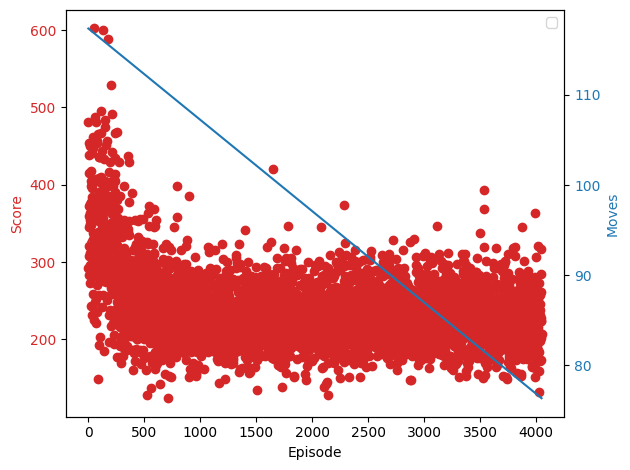

In [138]:
from tetris import TetrisApp

REWARDS = (INVALID_MOVE_REWARD, GAME_OVER_REWARD, VALID_MOVE_REWARD)
env = TetrisApp(ai=True, rewards=REWARDS)
dqn(env,
    num_episodes=NUM_EPISODES,
    batch_size=BATCH_SIZE,
    gamma=DISCOUNT_FACTOR,
    learning_rate=LEARNING_RATE)